In [ ]:
!pip install torch
!pip install kaggle
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from transformers import GPT2Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c nlp-getting-started

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory
nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip nlp-getting-started.zip -d /content/assignment_data

Archive:  nlp-getting-started.zip
replace /content/assignment_data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/assignment_data/sample_submission.csv  
  inflating: /content/assignment_data/test.csv  
  inflating: /content/assignment_data/train.csv  


In [ ]:
!ls /content/assignment_data

sample_submission.csv  test.csv  train.csv


In [ ]:
data = pd.read_csv("/content/assignment_data/train.csv")
print(data.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [ ]:
train_texts = data['text'].tolist()
train_targets = data['target'].tolist()

In [ ]:
train_texts[:5], train_targets[:5]

(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
  'Forest fire near La Ronge Sask. Canada',
  "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
  '13,000 people receive #wildfires evacuation orders in California ',
  'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '],
 [1, 1, 1, 1, 1])

Below create the prompt generator (check first)

In [ ]:

# Define your dataset
class PromptDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_length):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        target = self.targets[idx]
        encoded_text = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoded_text['input_ids'].squeeze(0)
        return input_ids, target

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
encoded = tokenizer.batch_encode_plus(train_texts, padding=True, truncation=True, return_tensors='pt')

text_train, text_val, target_train, target_val = train_test_split(train_texts, train_targets, test_size=0.2)

train_dataset = PromptDataset(text_train, target_train,tokenizer,50)
valid_dataset = PromptDataset(text_val, target_val,tokenizer,50)

trainloader = DataLoader(train_dataset, batch_size=32, shuffle = True)
validloader = DataLoader(valid_dataset, batch_size=32, shuffle = True)

In [ ]:
class PromptGenerator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, seq_length):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size * seq_length, output_size)
        self.seq_length = seq_length
        
    def forward(self, x):
        batch_size = x.size(0)
        #print(">>>",batch_size)
        _, (h_n, _) = self.rnn(x)
        out = self.fc(h_n.view(batch_size, -1))
        return out

    def generate(self, input_ids, max_length=50, device='cuda'):
        self.eval()
        with torch.no_grad():
          _, (prompt, _) = self.rnn(input_ids)
        return prompt #_text


In [ ]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(train_loader)

In [ ]:
def test(model, test_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_loss += loss.item()

    return epoch_loss / len(test_loader)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


input_size = 50
hidden_size = 32
output_size = 1
lr = 0.001
batch_size = 32
num_epochs = 50
seq_length=1

timetaken = 0
t_loss = []
v_loss = []
t_acc = []
v_acc = []
best_valid_loss = 0.999

model = PromptGenerator(input_size, hidden_size, output_size,seq_length)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    start_time = time.time()    
    # Training loop
    model.train()
    for batch in trainloader:
        x, y = batch
        optimizer.zero_grad()
        x = x.unsqueeze(0)
        x = x.float()
        y_pred = model(x)
        y = y.float()
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_size
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        for batch in validloader:
            x, y = batch
            x = x.unsqueeze(0)
            x = x.float()
            y_pred = model(x)
            y = y.float()
            loss = criterion(y_pred, y)
            val_loss += loss.item() * batch_size
            
    train_loss /= len(trainloader.dataset)
    val_loss /= len(validloader.dataset)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)    

    if val_loss < best_valid_loss:
      best_valid_loss = val_loss
      torch.save(model.state_dict(), 'best_prompt.pt')

    print(f'Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    t_loss.append(train_loss)
    v_loss.append(val_loss)

    timetaken += epoch_mins*60 + epoch_secs

print(f'Total time taken: {timetaken}s')


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, targe

Epoch 1 - Train Loss: 0.2683, Val Loss: 0.2772
Epoch 2 - Train Loss: 0.2641, Val Loss: 0.2599
Epoch 3 - Train Loss: 0.2557, Val Loss: 0.2569
Epoch 4 - Train Loss: 0.2557, Val Loss: 0.2484
Epoch 5 - Train Loss: 0.2502, Val Loss: 0.2484
Epoch 6 - Train Loss: 0.2492, Val Loss: 0.2489
Epoch 7 - Train Loss: 0.2500, Val Loss: 0.2505
Epoch 8 - Train Loss: 0.2483, Val Loss: 0.2492
Epoch 9 - Train Loss: 0.2480, Val Loss: 0.2470
Epoch 10 - Train Loss: 0.2480, Val Loss: 0.2476
Epoch 11 - Train Loss: 0.2487, Val Loss: 0.2469
Epoch 12 - Train Loss: 0.2479, Val Loss: 0.2472
Epoch 13 - Train Loss: 0.2474, Val Loss: 0.2463
Epoch 14 - Train Loss: 0.2475, Val Loss: 0.2463
Epoch 15 - Train Loss: 0.2468, Val Loss: 0.2484
Epoch 16 - Train Loss: 0.2475, Val Loss: 0.2478
Epoch 17 - Train Loss: 0.2474, Val Loss: 0.2469
Epoch 18 - Train Loss: 0.2470, Val Loss: 0.2464
Epoch 19 - Train Loss: 0.2468, Val Loss: 0.2466
Epoch 20 - Train Loss: 0.2470, Val Loss: 0.2470
Epoch 21 - Train Loss: 0.2463, Val Loss: 0.2462
E

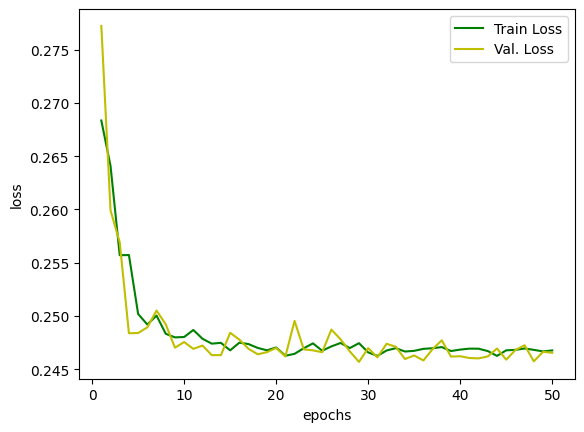

In [ ]:
# display the result out graphically

eps = range(1, num_epochs+1)

plt.plot(eps,t_loss,"g", label="Train Loss")
plt.plot(eps,v_loss,"y", label="Val. Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()


plt.show()

In [ ]:

#mymodel = PromptGenerator(input_size, hidden_size, output_size,seq_length)
#model_dict = torch.load('best_prompt.pt')    #assume the best prompt is here >> from validation loss
#print(model_dict.keys())
#model.load_state_dict('best_prompt.pt')

''''''
def generate_prompt(text):
    input_ids = tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    input_ids = tokenizer.batch_encode_plus(text, padding=True, truncation=True, return_tensors='pt')  
    prompt =model.generate(input_ids)
    prompt_text = tokenizer.decode(prompt[0], skip_special_tokens=True)
    return prompt_text

# use the training text to generate prompt
prompts = [generate_prompt(text) for text in train_texts]
print(prompts[:5])
train_dataset = PromptDataset(train_texts, prompts, tokenizer)
''''''


AttributeError: ignored